## Maximum Likelihood as a linear reegression problem

**Goal:** Demonstrate the maximum likelihood approach for regression on a simple example. 

**Usage:** Step through the code to get a better understanding.

**Dataset:** 

**Content:**

[open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book_playground/blob/master/demo_likelihood.ipynb)


#### Imports

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation
from tensorflow.keras import optimizers

tf.__version__

'2.0.0-alpha0'

Here we read in the systolic blood pressure and the age of the 33 American women in our dataset. Then we use the sklearn library to find the optimal values for the slope a and the intercept b.

Calculates the density $f(y,\mu,\sigma)$ of a normal distribution at $y$, given the parameters $\mu$ and $\sigma$ using:

$$
  f(y, \mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{(y - \mu)^2}{2 \sigma^2}}
$$



In [17]:
def f(y, mu, sigma=20):
  return (1/(sigma * tf.math.sqrt(2 * np.pi)) * tf.math.exp( - (y - mu)**2 / (2 * sigma**2)))

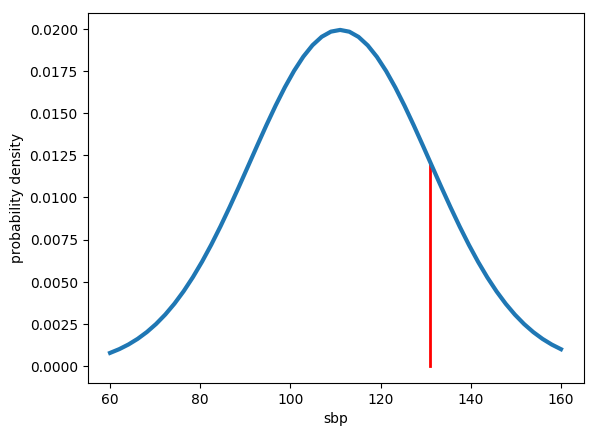

In [19]:
plt.style.use('default') 
sbp = np.linspace(60,160,50, dtype='float32')
plt.plot([131, 131], [0, f(131,111)], 'k-', lw=2,color='red')
plt.plot(sbp, f(sbp, 111),linewidth=3)
plt.xlabel('sbp')
plt.ylabel('probability density')
plt.savefig('ch4_10b.pdf')

In [14]:
f(131, 111)

0.01209853622595717

In [22]:
# Blood Pressure data
x = [22, 41, 52, 23, 41, 54, 24, 46, 56, 27, 47, 57, 28, 48, 58,  9, 
     49, 59, 30, 49, 63, 32, 50, 67, 33, 51, 71, 35, 51, 77, 40, 51, 81]
y = [131, 139, 128, 128, 171, 105, 116, 137, 145, 106, 111, 141, 114, 
     115, 153, 123, 133, 157, 117, 128, 155, 122, 183,
     176,  99, 130, 172, 121, 133, 178, 147, 144, 217] 
x = np.asarray(x, np.float32) 
y = np.asarray(y, np.float32)
n = len(y)

Creating a custom loss function. In order to create a custom loss function in Keras. You have to follow the interface 
 `loss(y_true, y_pred)`.
 
Here we define the loss as follows:
$
    l = -\sum_{i=1}^n \log (f(y_i, a \cdot x+b)) =  -\sum_{i=1}^n \log(f(y_i, ypred_i)) 
$

In [60]:
# 10          20       30        40       50         55
#1234567890123456789012345678901234567890123456789012345

def my_loss(y_true,y_pred): #A
  loss = -tf.reduce_sum(tf.math.log(f(y_true,y_pred)))
  return loss

model = Sequential() #B
model.add(Dense(1, activation='linear', #B
                batch_input_shape=(None, 1)))
model.compile(loss=my_loss,optimizer="adam")

#A Definition of a custom loss function
#B Set up of a network being equivalent to linear regression. One linear activation and a bias term.

In [59]:
for i in range(0,80000):
    model.fit(x=x,y=y,batch_size=33,
                    epochs=1,
                    verbose = 0)
    a,b=model.get_weights()
    if i % 5000==0:
        mse=np.mean(np.square(model.predict(x).reshape(len(x),)-y))
        print("Epoch:",i,"slope=",a[0][0],"intercept=",b[0],"MSE=",mse)

#Should reach
#1.   optimal value for slope: 1.1050216
#2.   optimal value for intercept: 87.67143
#3.   minimal MSE: 349.200787168560

Epoch: 0 slope= 1.113173 intercept= 87.248886 MSE= 349.22073
Epoch: 5000 slope= 1.1050298 intercept= 87.67142 MSE= 349.2009
Epoch: 10000 slope= 1.1050212 intercept= 87.671425 MSE= 349.2009
Epoch: 15000 slope= 1.1050211 intercept= 87.671425 MSE= 349.2008
Epoch: 20000 slope= 1.1050293 intercept= 87.671425 MSE= 349.20087
Epoch: 25000 slope= 1.1049621 intercept= 87.67135 MSE= 349.20087
Epoch: 30000 slope= 1.1050223 intercept= 87.67142 MSE= 349.20087
Epoch: 35000 slope= 1.1050222 intercept= 87.671425 MSE= 349.20087
Epoch: 40000 slope= 1.1050199 intercept= 87.671425 MSE= 349.20087
Epoch: 45000 slope= 1.1050211 intercept= 87.67142 MSE= 349.20087
Epoch: 50000 slope= 1.1050196 intercept= 87.67142 MSE= 349.20087
Epoch: 55000 slope= 1.1050259 intercept= 87.67143 MSE= 349.20093
Epoch: 60000 slope= 1.1050081 intercept= 87.67141 MSE= 349.2009
Epoch: 65000 slope= 1.1050216 intercept= 87.671425 MSE= 349.2008
Epoch: 70000 slope= 1.1050404 intercept= 87.67143 MSE= 349.20087
Epoch: 75000 slope= 1.1050274

### Independence of sigma

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  


*Exercise: Change the value of sigma in the calculation of the likelihood. Does the result depend on it?